This code is for the Data Analytics Project by team WeRAnalysers.
It is the final code after cleaning.The NA value replacement has already been done and it's code can be found on our github.It is not being included in the final
code as it takes almost 1hr to execute. The dataset after the preprocessing(NA replacement as well as dropping of negative values) has been uploaded and is used i.e.**india_noNA.csv**. 
This dataset has been created from the following three initial datasets: 2016_india.csv,2017_india.csv and 2018_india.csv 
This code contains all the major visualizations as well as the SARIMA model.
For the initial visualisations please refer the Stocktaking.ipynb file on github.
Other datasets on kaggle have also been used.
Link : https://www.kaggle.com/rstogi896/rainfall-in-india#Sub_Division_IMD_2017.csv

The AQI standards followed are those implemented by http://www.indiaenvironmentportal.org.in/files/file/Air%20Quality%20Index.pdf


In [1]:
#Importing libraries
import numpy as np
import pandas as pd 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from ipywidgets import widgets
import seaborn as sns
import folium
from folium.plugins import TimestampedGeoJson
from datetime import date
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
#Reading files
df=pd.read_csv("/kaggle/input/air-pollution-dataset-india20162018/india_noNA.csv")
df_rainfall = pd.read_csv("../input/rainfall-in-india/Sub_Division_IMD_2017.csv")
df_temp = pd.read_csv("/kaggle/input/montly-temperature-india-19012017/Mean_Temp_IMD_2017.csv")

In [3]:
#Check for NA values even after the cleaning process, if any drop them
print("NA values even after cleaning :",df.latitude.isna().sum())
df=df.dropna(axis=0)
df=df.reset_index(drop=True)

NA values even after cleaning : 94933


**--Simple Pie chart **

In [4]:
values=[]
par=df.parameter.value_counts()
for i in range(len(par)):
    values.append(par[i])
labels=['no2','co','pm25','o3','so2','pm10']
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen','red','black']
fig_pie = go.Figure(data=[go.Pie(labels=labels, 
                             values=values)])
fig_pie.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig_pie.show()

**--Base Graph/Dropdown to be used to identify patterns to be further investigated--**

In [5]:
#---MAIN DROPDOWN
#Creating a new dataframe where I have removed the time part of utc because we will be working with daily data and not hourly
data_dropdown=df

#Dropping unwanted attributes and stripping the time from the datetime format
data_dropdown=data_dropdown.drop(['local','country','attribution','location'],axis=1)
data_dropdown['utc'] = data_dropdown['utc'].map(lambda x: str(x)[:-14])
#Converting to datetime
data_dropdown['utc']=pd.to_datetime(data_dropdown['utc'],format="%Y-%m-%d")

#Creating an aggregated dataframe
agg_data_dropdown=data_dropdown
#Grouping by the 3 columns to get unique values
grouped_dropdown=agg_data_dropdown.groupby(['utc','city','parameter'])
#Getting mean of each column
grouped_dropdown=grouped_dropdown.mean()

In [6]:
#So basically now what we get is a heirarchically indexed dataframe, so the three columns together form the index and are no more
#available as separate columns
grouped_dropdown

value   latitude  longitude
utc        city          parameter                                  
2016-01-03 Chennai       pm25        32.333333  13.051966  80.235423
           Delhi         pm25       381.666667  28.633446  77.174244
           Hyderabad     pm25        65.500000  17.385070  78.455439
           Kolkata       pm25       330.333333  22.588437  88.368451
           Mumbai        pm25       163.833333  19.068058  72.896524
...                                        ...        ...        ...
2018-04-06 Visakhapatnam no2         43.666667  17.720000  83.300000
                         o3          10.166667  17.720000  83.300000
                         pm10        86.416667  17.720000  83.300000
                         pm25        57.416667  17.720000  83.300000
                         so2         12.916667  17.720000  83.300000

[120945 rows x 3 columns]

In [7]:
#Inserting those columns from the index again so that we can make accessing easier
grouped_dropdown.insert(3,'date',pd.to_datetime('2016-01-03'))
grouped_dropdown.insert(4,'parameter',0)
grouped_dropdown.insert(5,'city',0)

In [8]:
#Copying the values from index to the newly added row
for i in grouped_dropdown.index:
    grouped_dropdown.date[i]=i[0]
    grouped_dropdown.parameter[i]=i[2]
    grouped_dropdown.city[i]=i[1]
    #print(grouped_dropdown.date[i])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying 

In [9]:
#The grouped dropdown
grouped_dropdown.head()

value   latitude  longitude       date  \
utc        city      parameter                                                
2016-01-03 Chennai   pm25        32.333333  13.051966  80.235423 2016-01-03   
           Delhi     pm25       381.666667  28.633446  77.174244 2016-01-03   
           Hyderabad pm25        65.500000  17.385070  78.455439 2016-01-03   
           Kolkata   pm25       330.333333  22.588437  88.368451 2016-01-03   
           Mumbai    pm25       163.833333  19.068058  72.896524 2016-01-03   

                               parameter       city  
utc        city      parameter                       
2016-01-03 Chennai   pm25           pm25    Chennai  
           Delhi     pm25           pm25      Delhi  
           Hyderabad pm25           pm25  Hyderabad  
           Kolkata   pm25           pm25    Kolkata  
           Mumbai    pm25           pm25     Mumbai

In [10]:
#Initial content for dropdown i.e city=Delhi and pollutant = 'pm25'
filter_list = [i and j for i, j in
        zip(grouped_dropdown['city'] == 'Delhi', grouped_dropdown['parameter'] == 'pm25')]
#Creating a temporary dataframe holding only the filtered rows
temp_df = grouped_dropdown[filter_list]

In [11]:
#Making the dropdown as an Interactive Widget
city = widgets.Dropdown(
    description='City:   ',
    value='Delhi',
    options=grouped_dropdown['city'].unique().tolist()
)
parameter = widgets.Dropdown(
    options=list(grouped_dropdown['parameter'].unique()),
    value='pm25',
    description='Parameter:   ',
)
trace1 = go.Scatter(x=temp_df['date'], y=temp_df['value'], mode='markers')

g = go.FigureWidget(data=[trace1],
                    layout=go.Layout(
                        title=dict(
                            text='Pollutant concentrations for different cities'
                        )
                    ))

#Function to keep track of the inputs of the user
def response(change):
        filter_list = [i and j for i, j in
        zip(grouped_dropdown['city'] == city.value, grouped_dropdown['parameter'] == parameter.value)]
        temp_df = grouped_dropdown[filter_list]
        x1 = temp_df['date']
        y1 = temp_df['value']
        with g.batch_update():
            g.data[0].x = x1
            g.data[0].y = y1
            g.layout.xaxis.title = 'Date'
            g.layout.yaxis.title = 'Pollutant levels'


city.observe(response, names="value")
parameter.observe(response, names="value")
container2 = widgets.HBox([city, parameter])
widgets.VBox([container2,g])

* A general trend that can be observed in most of the cities is that the levels of pm10 during the monsoon months of July-October are considerably low as compared to the neighboring seasons. This is due to wet deposition and air scrubbing by rainfall.
* But another striking feature is that we observe that in Delhi the plot of pm10 shows a U shape with the peaks occuring between November - January. This trend can be observed for pm25 values for Kolkata as well. We will try to understand this trend better as we move forward.
* Bengaluru seems to have more or less a stable pollutant concentration. There appears to be no trend in general. This seems to strengthen the fact that "Namma bengaluru Garden city".<br>
Finer details will be investigated as we move through the study.

In [12]:
#Creating a new dataframe consisting of monthly aggregated data i.e per month per city per pollutant
data_monthly_dropdown=df
data_monthly_dropdown=data_monthly_dropdown.drop(['local','country','attribution','location','unit'],axis=1)
data_monthly_dropdown['utc'] = data_monthly_dropdown['utc'].map(lambda x: str(x)[:-17])
#Converting to datetime
data_monthly_dropdown['utc']=pd.to_datetime(data_monthly_dropdown['utc'])

#Creating an aggregated dataframe
agg_monthly_dropdown=data_monthly_dropdown
#Grouping by the 3 columns to get unique values
grouped_monthly_dropdown=agg_monthly_dropdown.groupby(['utc','city','parameter'])
#Getting mean of each column
grouped_monthly_dropdown=grouped_monthly_dropdown.mean()


#Adding new columns for ease of work
grouped_monthly_dropdown.insert(3,'date',pd.to_datetime('2016-01'))
grouped_monthly_dropdown.insert(4,'city',0)
grouped_monthly_dropdown.insert(5,'parameter',0)

for i in grouped_monthly_dropdown.index:
    grouped_monthly_dropdown.date[i]=i[0]
    grouped_monthly_dropdown.city[i]=i[1]
    grouped_monthly_dropdown.parameter[i]=i[2]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**--MAP Showing Pollution levels across India over the years-- **

In [13]:
#------------------MAP----------------
#Define a dictionary consisting of the pollutant and its categories of severity as specified by the  http://www.indiaenvironmentportal.org.in/files/file/Air%20Quality%20Index.pdf
pollutants = {
    'so2': {
        'notation' : 'SO2',
        'name' :'Sulphur dioxide',
        'bin_edges' : np.array([15,30,45,60,80,100,125,165,250])
    },
    'pm10': {
        'notation' : 'PM10',
        'name' :'Particulate matter < 10 µm',
        'bin_edges' : np.array([10,20,30,40,50,70,100,150,200])
    },
    'o3': {'notation' : 'O3',
        'name' :'Ozone',
        'bin_edges' : np.array([30,50,70,90,110,145,180,240,360])
    },
    'no2': {'notation' : 'NO2',
        'name' :'Nitrogen dioxide',
        'bin_edges' : np.array([25,45,60,80,110,150,200,270,400])
    },
    'co': {'notation' : 'CO',
        'name' :'Carbon monoxide',
         'bin_edges' : np.array([1.4,2.1,2.8,3.6,4.5,5.2,6.6,8.4,13.7])
    },
    'pm25': {
        'notation' : 'PM25',
        'name' :'Particulate matter < 25 µm',
        'bin_edges' : np.array([10,20,30,40,50,70,100,150,200])
    }
    
}

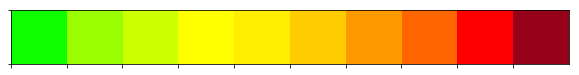

In [14]:
#Defining volor scale for the map
color_scale = np.array(['#10ff00','#99ff00','#ccff00','#ffff00','#ffee00','#FFCC00','#ff9900','#ff6600','#ff0000','#960018'])
sns.palplot(sns.color_palette(color_scale))

In [15]:
import warnings
warnings.filterwarnings("ignore")
#Functions to load data, color code the date and create geojson  features
def load_data(pollutant_ID,grouped_monthly_dropdown):
   
    agg_ts = grouped_monthly_dropdown[grouped_monthly_dropdown['parameter']==pollutant_ID]
    return agg_ts

def color_coding(poll, bin_edges):    
    idx = np.digitize(poll, bin_edges, right=True)
    return color_scale[idx]


def prepare_data(df, pollutant_ID):
    
    df['color'] = df.value.apply(color_coding, bin_edges=pollutants[pollutant_ID]['bin_edges'])
    return df

def create_geojson_features(df):
  
    
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['longitude'],row['latitude']]
            },
            'properties': {
                'time': row['date'].date().__str__(),
                'style': {'color' : row['color']},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 7
                }
            }
        }
        features.append(feature)
    return features

def make_map(features):
    
    coords_delhi=[28.65381,77.22897]
    pollution_map = folium.Map(location=coords_delhi, control_scale=True, zoom_start=8)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1M'
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY/MM'
        , time_slider_drag_update=True
    ).add_to(pollution_map)
    print('> Done.')
    return pollution_map

def plot_pollutant(pollutant_ID):
    print('Mapping {} pollution in India in 2016-2018'.format(pollutants[pollutant_ID]['name']))
    pollutant_map_df = load_data(pollutant_ID,grouped_monthly_dropdown)
    pollutant_map_df = prepare_data(pollutant_map_df, pollutant_ID)
    features = create_geojson_features(pollutant_map_df)
    return make_map(features), pollutant_map_df



In [16]:
#MAP for No2, slide the slider to see it varying over time
pollution_map_no2, pollutant_map_df_no2 = plot_pollutant('no2')
pollution_map_no2.save('/kaggle/input/pollution_no2.html')
pollution_map_no2

Mapping Nitrogen dioxide pollution in India in 2016-2018
> Done.


The NO2 concentrations appears to be constant through the 2 year time period. Towards the end of 2016, there seemed to be a slight increase in the pollutant levels but appears to have reduced thereafter. <br>There are no striking values that can be observed. 

In [17]:
#Map for CO
pollution_map_co, pollutant_map_df_co = plot_pollutant('co')
pollution_map_co.save('/kaggle/input/pollution_co.html')
pollution_map_co

Mapping Carbon monoxide pollution in India in 2016-2018
> Done.


The CO levels appear to be extremely high throughout the duration. Pollution from vehicles is a major contributor to high carbon monoxide levels. <br>However, researchers believe winds carry the CO produced by biomass burning in Africa and Southeast Asian countries to the Indian subcontinent, thus adding to the already high levels of the gas in the country's atmosphere. <br>
This appears to be a plausible explanation but we cannot be sure since the data can be misrepresentative.

In [18]:
#Map for o3
pollution_map_o3, pollutant_map_df_o3 = plot_pollutant('o3')
pollution_map_o3.save('/kaggle/input/pollution_o3.html')
pollution_map_o3

Mapping Ozone pollution in India in 2016-2018
> Done.


The Ozone levels also appear to be stationary and there seems to be no sudden change.

In [19]:
#Map for pm10
pollution_map_pm10, pollutant_map_df_pm10 = plot_pollutant('pm10')
pollution_map_pm10.save('/kaggle/input/pollution_pm10.html')
pollution_map_pm10

Mapping Particulate matter < 10 µm pollution in India in 2016-2018
> Done.


The general trend that can be observed is the the concentration of pm10 has been increasing. There appeared to be a phase in between when the levels had gone down but they shot back up right after.

In [20]:
#Map for pm25
pollution_map_pm25, pollutant_map_df_pm25 = plot_pollutant('pm25')
pollution_map_pm25.save('/kaggle/input/pollution_pm25.html')
pollution_map_pm25

Mapping Particulate matter < 25 µm pollution in India in 2016-2018
> Done.


The pm25 values initially seemed to be improving as they moved to the greener side but they steadily move towards the red palette indicating deteriorating air quality.

**--Diwali--**

In [21]:
#data for diwali of the three years
#2016 - Sun 30 Oct
#2017 - Thu 19 Oct
#2018 - Wed 7 Nov

#2016 dates - 28,29,30,31,1 Oct-Nov
#2017 dates - 17,18,19,20,21 Oct
#2018 dates - 5,6,7,8,9 Nov

#2016 -> 20,21,22,23,24,25,26,27,28,29, 30 ,31,1,2,3,4,5,6,7,8,9
#2017 -> 9,10,11,12,13,14,15,16,17,18, 19 ,20,21,22,23,24,25,26,27,28,29

#bursting of crackers - ozone, no2, so2
#burning of fuels - pm, co, no2, so2

In [22]:
#grouping the data to get one value per city, per pollutant, per day
data_daily_diwali=df
data_daily_diwali=data_daily_diwali.drop(['utc','country','attribution','location','unit'],axis=1)
data_daily_diwali['local'] = data_daily_diwali['local'].map(lambda x: str(x)[:10])
data_daily_diwali['local']=pd.to_datetime(data_daily_diwali['local'],format="%Y-%m-%d")

agg_daily_diwali=data_daily_diwali
grouped_daily_diwali=agg_daily_diwali.groupby(['local','city','parameter'])
grouped_daily_diwali=grouped_daily_diwali.mean()

grouped_daily_diwali.insert(3,'date',pd.to_datetime('2016-01'))
grouped_daily_diwali.insert(4,'city',0)
grouped_daily_diwali.insert(5,'parameter',0)

for i in grouped_daily_diwali.index:
    grouped_daily_diwali.date[i]=i[0]
    grouped_daily_diwali.city[i]=i[1]
    grouped_daily_diwali.parameter[i]=i[2]

grouped_daily=grouped_daily_diwali

In [23]:
#getting dates for diwali days
y16_oct = list(range(20,32))
y16_nov = list(range(1,10))
y17 = list(range(9,30))

y_comb = [y16_oct, y16_nov, y17]
year_month = ["2016-10-", "2016-11-", "2017-10-"]
dat = []
for i in range(len(y_comb)):
    for j in range(len(y_comb[i])):
        if (y_comb[i][j] < 10):
            y_comb[i][j] = '0' + str(y_comb[i][j])
        else:
            y_comb[i][j] = str(y_comb[i][j])

#print("Diwali dates across the years = ", y_comb)

We create a dropdown for choosing the city and pollutant to see the trend for the five days of diwali as compared to 10 days before and after

In [24]:

#-----------------------------------------creating temp dataframe to hold the values of the diwali dates--------------------------
#Initial for Delhi and No2
df_sub = grouped_daily_diwali.loc[grouped_daily_diwali['city'] == 'Delhi']
df_sub = df_sub.loc[df_sub['parameter'] == 'no2']

years_data = []
for ym in range(len(year_month)):
    y = []
    for d in y_comb[ym]:
        c = year_month[ym] + d
        df1_sub = df_sub[df_sub['date'].astype(str).str.contains(c)]
        yd = df1_sub.value.mean()
        y.append(yd)
    years_data.append(y)

y16 = []
for i in years_data[0]:
    y16.append(i)
for i in years_data[1]:
    y16.append(i)

y17_data = []
for i in years_data[2]:
    y17_data.append(i)

#--------------------------------------- Create a dropdown ---------------------------------------------------

city_diwali = widgets.Dropdown(
    description='City:   ',
    value='Delhi',
    options=grouped_daily_diwali['city'].unique().tolist()
)
parameter_diwali = widgets.Dropdown(
    options=list(grouped_daily_diwali['parameter'].unique()),
    value='no2',
    description='Parameter:   ',
)

trace1_diwali = go.Scatter(y=y16, mode='lines', name='year 2016', line=dict(color='rgb(255, 133, 133)'))
trace2_diwali = go.Scatter(y=y17_data, mode='lines', name='Year 2017', line=dict(color='rgb(16, 216, 235)'))
trace3_diwali = go.Scatter(y=y16[8:13], x = list(range(8,13)), name = "Diwali day 2016", line=dict(color='rgb(250, 5, 5)'))
trace4_diwali = go.Scatter(y=y17_data[8:13], x = list(range(8,13)), name = "Diwali day 2017", line=dict(color='rgb(12, 10, 128)'))

g_diwali = go.FigureWidget(data=[trace1_diwali, trace2_diwali, trace3_diwali, trace4_diwali],
                    layout=go.Layout(
                        title=dict(
                            text='Pollutant levels during diwali days for 2016,2017'
                        )
                    ))

def response(change):
        #-----------------------------------------creating temp dataframe--------------------------
        df_sub = grouped_daily_diwali.loc[grouped_daily_diwali['city'] == city_diwali.value]
        df_sub = df_sub.loc[df_sub['parameter'] == parameter_diwali.value]

        years_data = []
        for ym in range(len(year_month)):
            y = []
            for d in y_comb[ym]:
                c = year_month[ym] + d
                df1_sub = df_sub[df_sub['date'].astype(str).str.contains(c)]
                yd = df1_sub.value.mean()
                y.append(yd)
            years_data.append(y)

        y16 = []
        for i in years_data[0]:
            y16.append(i)
        for i in years_data[1]:
            y16.append(i)

        y17_data = []
        for i in years_data[2]:
            y17_data.append(i)        
        #------------------------------------------------------------------------------------------
        y0 = y16
        y1 = y17_data
        y2 = y16[8:13]
        x2 = list(range(8,13))
        y3 = y17_data[8:13]
        x3 = list(range(8,13))
        with g_diwali.batch_update():
            g_diwali.data[0].y = y0
            g_diwali.data[1].y = y1
            g_diwali.data[2].y = y2
            g_diwali.data[3].y = y3
            g_diwali.data[2].x = x2
            g_diwali.data[3].x = x3
            g_diwali.layout.xaxis.title = 'Date'
            g_diwali.layout.yaxis.title = 'Pollutant levels'


city_diwali.observe(response, names="value")
parameter_diwali.observe(response, names="value")
container2_diwali = widgets.HBox([city_diwali, parameter_diwali])
widgets.VBox([container2_diwali,g_diwali])

Since people burst a lot of crackers during diwali, we expect an increase in the pollutant levels.
* We notice that there is a sharp rise in the NO2 levels in 2016, in Delhi, for the second day of Diwali as compared to the days before and after. This is in accordance with what we expected. Also, the pollutant levels are higher in 2016 than in 2017 which could suggest that people are becoming more sensitive towards the environment now.
* In Mumbai as well, we notice that 2016 NO2 values are much higher than 2017 ones. And for 2017, the graph peaks on third day of Diwali. This is again in accordance with the expectation. And pm2.5 and pm10 values are much higher during the five days than the remaining.
* In Bengaluru 2017, pm10 rises to very high levels during Diwali
* Jodhpur also shows very high trends of pm10 during those days for both the years.

**--Weekend vs Weekday--**

In [25]:
#function to get the day from the given date
def get_day(my_date):
    my_date = str(my_date)
    y = int(my_date[:4])
    m = int(my_date[5:7])
    d = int(my_date[8:10])

    my_day = date(y, m, d).weekday()
    return calendar.day_name[my_day]

In [26]:
#Dropdown For Weekend vs Weekday
#-----------------------------------------creating temp dataframe--------------------------
weekday = pd.DataFrame()
weekend = pd.DataFrame()
df_no2 = grouped_daily_diwali.loc[grouped_daily_diwali['parameter'] == 'no2']
df_no2 = df_no2.loc[df_no2['city'] == 'Delhi']
df_no2 = df_no2[df_no2['date'].astype(str).str.contains("2016")]

for i in range(len(df_no2)):
    if ((get_day(df_no2.iloc[i,3]) == 'Sunday') or (get_day(df_no2.iloc[i,3]) == 'Saturday')):
        weekend = weekend.append(df_no2.iloc[i,:])
    else:
        weekday = weekday.append(df_no2.iloc[i,:])

#----------------------------------- Create the dropdown -------------------------------------------------------

city_ww = widgets.Dropdown(
    description='City:   ',
    value='Delhi',
    options=grouped_daily_diwali['city'].unique().tolist()
)

parameter_ww = widgets.Dropdown(
    options=list(grouped_daily_diwali['parameter'].unique()),
    value='no2',
    description='Parameter:   ',
)

year_ww = widgets.Dropdown(
    options=["2016","2017","2018"],
    value='2016',
    description='Year:   ',
)

trace1_ww = go.Bar(x=weekend['date'], y=weekend['value'], name='Weekends')
trace2_ww = go.Bar(x=weekday['date'], y=weekday['value'], name='Weekdays')
g_ww = go.FigureWidget(data=[trace1_ww, trace2_ww],
                    layout=go.Layout(
                        title=dict(
                            text='Pollutant levels on weekends vs weekdays'
                        )
                    ))
def response(change):

        #-----------------------------------------creating temp dataframe--------------------------
        weekday = pd.DataFrame()
        weekend = pd.DataFrame()
        df_no2 = grouped_daily_diwali.loc[grouped_daily_diwali['parameter'] == parameter_ww.value]
        df_no2 = df_no2.loc[df_no2['city'] == city_ww.value]
        df_no2 = df_no2[df_no2['date'].astype(str).str.contains(year_ww.value)]

        for i in range(len(df_no2)):
            if ((get_day(df_no2.iloc[i,3]) == 'Sunday') or (get_day(df_no2.iloc[i,3]) == 'Saturday')):
                weekend = weekend.append(df_no2.iloc[i,:])
            else:
                weekday = weekday.append(df_no2.iloc[i,:])
        #------------------------------------------------------------------------------------------

        x0 = weekend['date']
        y0 = weekend['value']
        x1 = weekday['date']
        y1 = weekday['value']
        with g_ww.batch_update():
            g_ww.data[0].x = x0
            g_ww.data[0].y = y0
            g_ww.data[1].x = x1
            g_ww.data[1].y = y1
            g_ww.layout.xaxis.title = 'Date'
            g_ww.layout.yaxis.title = 'Pollutant levels of ' + parameter_ww.value

city_ww.observe(response, names="value")
parameter_ww.observe(response, names="value")
year_ww.observe(response, names="value")
container2_ww = widgets.HBox([city_ww, parameter_ww,year_ww])
widgets.VBox([container2_ww,g_ww])

From this plot we can gain the following insights - 
* The pm2.5 values for Delhi in 2016 are extremely high on 6th November. If we look up what happened on that day, we notice that on this day the Indian government declared levels of air pollution in Delhi as an emergency situation, closing schools and construction sites. Pm2.5 particles are very harmful because they can reach deep into the lungs and breach the blood-brian barrier. And on this day the pm2.5 levels had reached values more thann 16 times the safe limit. This is very alarming.
* The concentration of CO on 3rd December, 2017 was tremendously high compared to the neighbouring values. And when we search for what happened on this day as well, we found that there was a cricket match organinsed between India and Sri Lanka. And the players were forced to wear masks and many complained of breathing problems. This news had made headlines. Thus our observation from the data is validated by true events that have occured on those days

In [27]:
#Box plot for weekend vs weekday
#-----------------------------------------creating temp dataframe--------------------------
weekday_box = pd.DataFrame()
weekend_box = pd.DataFrame()
df_no2_box = grouped_daily_diwali.loc[grouped_daily_diwali['parameter'] == 'no2']
df_no2_box = df_no2_box.loc[df_no2_box['city'] == 'Delhi']
df_no2_box = df_no2_box[df_no2_box['date'].astype(str).str.contains("2016")]

for i in range(len(df_no2_box)):
    if ((get_day(df_no2_box.iloc[i,3]) == 'Sunday') or (get_day(df_no2_box.iloc[i,3]) == 'Saturday')):
        weekend_box = weekend_box.append(df_no2_box.iloc[i,:])
    else:
        weekday_box = weekday_box.append(df_no2_box.iloc[i,:])
#------------------------------------------------------------------------------------------

city_ww_box = widgets.Dropdown(
    description='City:   ',
    value='Delhi',
    options=grouped_daily_diwali['city'].unique().tolist()
)

parameter_ww_box = widgets.Dropdown(
    options=list(grouped_daily_diwali['parameter'].unique()),
    value='no2',
    description='Parameter:   ',
)

year_ww_box = widgets.Dropdown(
    options=["2016","2017","2018"],
    value='2016',
    description='Year:   ',
)

trace0_ww_box = go.Box(y=weekday_box['value'], name = 'Weekdays')
trace1_ww_box = go.Box(y=weekend_box['value'], name = 'Weekends')
g_ww_box = go.FigureWidget(data=[trace0_ww_box, trace1_ww_box],
                    layout=go.Layout(
                        title=dict(
                            text='Pollutant levels on weekends vs weekdays'
                        )
                    ))
def response(change):

        #-----------------------------------------creating temp dataframe--------------------------
        weekday_box = pd.DataFrame()
        weekend_box = pd.DataFrame()
        df_no2_box = grouped_daily_diwali.loc[grouped_daily_diwali['parameter'] == parameter_ww_box.value]
        df_no2_box = df_no2_box.loc[df_no2_box['city'] == city_ww_box.value]
        df_no2_box = df_no2_box[df_no2_box['date'].astype(str).str.contains(year_ww_box.value)]

        for i in range(len(df_no2_box)):
            if ((get_day(df_no2_box.iloc[i,3]) == 'Sunday') or (get_day(df_no2_box.iloc[i,3]) == 'Saturday')):
                weekend_box = weekend_box.append(df_no2_box.iloc[i,:])
            else:
                weekday_box = weekday_box.append(df_no2_box.iloc[i,:])
        #------------------------------------------------------------------------------------------

        y0 = weekday_box['value']
        y1 = weekend_box['value']
        with g_ww_box.batch_update():
            g_ww_box.data[0].y = y0
            g_ww_box.data[1].y = y1
            g_ww_box.layout.xaxis.title = 'Date'
            g_ww_box.layout.yaxis.title = 'Pollutant levels of ' + parameter_box.value


city_ww_box.observe(response, names="value")
parameter_ww_box.observe(response, names="value")
year_ww_box.observe(response, names="value")
container2_ww_box = widgets.HBox([city_ww_box, parameter_ww_box,year_ww_box])
widgets.VBox([container2_ww_box,g_ww_box])

We also wanted to see if there was any difference in pollutant levels between weekends and weekdays. The graph shows that there isn’t any significant difference between the two. The boxplot also shows the same. The values on weekdends is very slighty lesser than the weekady

**--AQI Calculations**

In [28]:
#AQI Code
#Formula for calculating AQI using linear segmengted formula
# p= [{(IHI - ILO)/ (BHI -BLO)} * (Cp-BLO)] + ILO
# 
# BHI= Breakpoint concentration greater or equal to given conc.
# BLO= Breakpoint concentration smaller or equal to given conc.
# 
# IHI = AQI value corresponding to BHI
# 
# ILO = AQI value corresponding to BLO


In [29]:
#Defining breakpoints for different pollutants as per http://www.indiaenvironmentportal.org.in/files/file/Air%20Quality%20Index.pdf
co_bp=[1000,2000,10000,17000,34000]
no2_bp=[40,80,180,280,400]
pm10_bp=[50,100,250,350,430]
pm25_bp=[30,60,90,150,250]
o3_bp=[50,100,200,265,748]
so2_bp=[40,80,380,800,1600]

#order in dictionary PM10 PM2.5 NO2 O3 CO SO2
dict_aqi_mapping_pm10={'0-50':[0,50],'51-100':[51,100],'101-200':[101,250],'201-300':[251,350],'301-400':[351,430],'401-500':[430,600]}
dict_aqi_mapping_pm25={'0-50':[0,30],'51-100':[31,60],'101-200':[61,90],'201-300':[91,120],'301-400':[121,250],'401-500':[250,400]}
dict_aqi_mapping_no2={'0-50':[0,40],'51-100':[41,80],'101-200':[81,180],'201-300':[181,280],'301-400':[281,400],'401-500':[400,600]}
dict_aqi_mapping_o3={'0-50':[0,50],'51-100':[51,100],'101-200':[101,168],'201-300':[169,208],'301-400':[209,748],'401-500':[748,900]}
dict_aqi_mapping_co={'0-50':[0,1000],'51-100':[1001,2000],'101-200':[2001,10000],'201-300':[10001,17000],'301-400':[17001,34000],'401-500':[34000,40000]}
dict_aqi_mapping_so2={'0-50':[0,40],'51-100':[41,80],'101-200':[81,380],'201-300':[381,800],'301-400':[801,1600],'401-500':[1600,2000]}

breakpoint_pm10=[0,50,100,250,350,430,600]
breakpoint_pm25=[0,30,60,90,150,250,400]
breakpoint_no2=[0,40,80,180,280,400,600]
breakpoint_o3=[0,50,100,200,265,748,900]
breakpoint_co=[0,1000,2000,10000,17000,34000,40000]
breakpoint_so2=[0,40,80,380,800,1600,2000]


In [30]:
#Function to calculate the AQI given the pollutant
def calculateAQI(cp,pollutant):
    if(pollutant=='pm10'):
        pollutant_bp=breakpoint_pm10
        pollutant_aqi_mapping=dict_aqi_mapping_pm10
    elif(pollutant=='pm25'):
        pollutant_bp=breakpoint_pm25
        pollutant_aqi_mapping=dict_aqi_mapping_pm25
    elif(pollutant=='no2'):
        pollutant_bp=breakpoint_no2
        pollutant_aqi_mapping=dict_aqi_mapping_no2
    elif(pollutant=='so2'):
        pollutant_bp=breakpoint_so2
        pollutant_aqi_mapping=dict_aqi_mapping_so2
    elif(pollutant=='o3'):
        pollutant_bp=breakpoint_o3
        pollutant_aqi_mapping=dict_aqi_mapping_o3
    elif(pollutant=='co'):
        pollutant_bp=breakpoint_co
        pollutant_aqi_mapping=dict_aqi_mapping_co
    if(cp==0):
        return 0
    flag=0
    j=pollutant_bp[0]
    for i in pollutant_bp:
        if(i>=cp and flag==0):
            bhi=i
            blo=j
            flag=1
        j=i
        
#--Arbitary value 600(Greater than max AQI possible)
    if(flag==0):
        return 600
    else:
        found_ihi=0
        found_ilo=0
        for i in pollutant_aqi_mapping.keys():
            if(pollutant_aqi_mapping[i][1]>=bhi and found_ihi==0):

                ihilo=i.split('-')
                ihi=float(ihilo[1])
                ilo=float(ihilo[0])
                found_ihi=1

        ip=(((ihi-ilo)/(bhi-blo))*(cp-blo))+ilo
        return ip

In [31]:
#Grouped on day,city,parameter
#Have to sort the df first
#Monthly not daily as map does not work for daily due to excessive amounts of data points
grouped_daily_AQI=grouped_monthly_dropdown
grouped_daily_AQI=grouped_daily_AQI.reset_index(drop=True)
grouped_daily_AQI=grouped_daily_AQI.sort_values(by=['date','city'])

city_l=[]
date_l=[]
val_l=[]
long_l=[]
lat_l=[]
temp_date=str(grouped_daily_AQI['date'][0])
temp_city=grouped_daily_AQI['city'][0]

l=[]
for i in grouped_daily_AQI.index:
    if str(grouped_daily_AQI.loc[i,'date'])==temp_date:
        
        if grouped_daily_AQI.loc[i,'city']!=temp_city:
            max_val=max(l)
            date_l.append(temp_date)
            city_l.append(temp_city)
            val_l.append(max_val)
            lat_l.append(grouped_daily_AQI.loc[i,'latitude'])
            long_l.append(grouped_daily_AQI.loc[i,'longitude'])
            temp_city=grouped_daily_AQI.loc[i,'city']
            l=[]
            l.append(calculateAQI(grouped_daily_AQI.loc[i,'value'],grouped_daily_AQI.loc[i,'parameter']))
        else:
            l.append(calculateAQI(grouped_daily_AQI.loc[i,'value'],grouped_daily_AQI.loc[i,'parameter']))
    else:
        l=[]
        temp_date=str(grouped_daily_AQI.loc[i,'date'])
        temp_city=grouped_daily_AQI.loc[i,'city']
        l.append(calculateAQI(grouped_daily_AQI.loc[i,'value'],grouped_daily_AQI.loc[i,'parameter']))
        
#Create new dataframe by going through dict_AQI

data_df = {'date':date_l,
        'city':city_l,
          'value_AQI':val_l,
          'latitude':lat_l,
          'longitude':long_l}
 
# Create DataFrame
df_AQI = pd.DataFrame(data_df)

In [32]:
#Create a new dataframe with the monthly data per city per pollutant along with its Textual Interpretation
l_text_AQI=[]
dict_aqi_mapping={50:'Good',100:'Satisfactory',200:'Moderately Polluted',300:'Poor',400:'Very Poor',500:'Severe',1000:'Extreme'}
for i in df_AQI.index:
    flag=0
    temp=df_AQI.loc[i,'value_AQI']
    for j,val in dict_aqi_mapping.items():
        if(flag!=0):
            break
        if(j>temp):
            l_text_AQI.append(val)
            flag=1
        
df_AQI['text_AQI']=l_text_AQI

In [33]:
df_AQI.head()

,date,city,value_AQI,latitude,longitude,text_AQI
0,2016-01-01 00:00:00,Chennai,81.270711,28.633446,77.174244,Satisfactory
1,2016-01-01 00:00:00,Delhi,422.282036,17.385070,78.455439,Severe
2,2016-01-01 00:00:00,Hyderabad,171.766667,22.588437,88.368451,Moderately Polluted
3,2016-01-01 00:00:00,Kolkata,340.901958,19.068058,72.896524,Very Poor
4,2016-02-01 00:00:00,Chennai,58.205172,28.633446,77.174244,Satisfactory


**--MAP for AQI--**

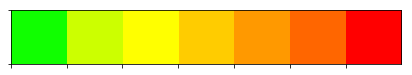

In [34]:
color_scale_AQI = np.array(['#10ff00','#ccff00','#ffff00','#FFCC00','#ff9900','#ff6600','#ff0000'])
sns.palplot(sns.color_palette(color_scale_AQI))

In [35]:
#----AQI MAP
pollutants_AQI={
    'value_AQI': {
        'notation' : 'AQI',
        'name' :'Air Quality Index(AQI)',
        'bin_edges' : np.array([50,100,200,300,400,500,1000])
    }
}


def color_coding_AQI(poll, bin_edges):    
    idx = np.digitize(poll, bin_edges, right=True)
    return color_scale_AQI[idx]


def prepare_data_AQI(df, pollutant_ID):
    print('> Preparing data...')
    #df = df.reset_index().merge(meta, how='inner', on='city').set_index('DatetimeBegin')
    #df = df.loc[:, ['SamplingPoint','Latitude', 'Longitude', 'AirPollutionLevel']]
    #df = df.groupby('SamplingPoint', group_keys=False).resample(rule='M').last().reset_index()
    df['color'] = df.value_AQI.apply(color_coding_AQI, bin_edges=pollutants_AQI[pollutant_ID]['bin_edges'])
    return df
def create_geojson_features_AQI(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['longitude'],row['latitude']]
            },
            'properties': {
                'time': row['date'],
                'style': {'color' : row['color']},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 7
                }
            }
        }
        features.append(feature)
    return features


def make_map_AQI(features):
    #print('> Making map...')
    coords_india=[28.65381,77.22897]
    pollution_map = folium.Map(location=coords_india, control_scale=True, zoom_start=4)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1M'
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY/MM/DD'
        , time_slider_drag_update=True
    ).add_to(pollution_map)
    #print('> Done.')
    return pollution_map

def plot_pollutant_AQI(pollutant_ID):
    print('Mapping {} levels in India during 2016-2018'.format(pollutants_AQI[pollutant_ID]['name']))
    #pollutant_map_df = load_data_AQI(pollutant_ID,df_AQI)
    #df = clean_data(df)
    pollutant_map_df_AQI = prepare_data_AQI(df_AQI, pollutant_ID)
    features = create_geojson_features_AQI(pollutant_map_df_AQI)
    return make_map_AQI(features), pollutant_map_df_AQI

#Change the name below to any polllutant you want i.e pollution_map, df = plot_pollutant('no2')
pollution_map_AQI, pollutant_map_df_AQI = plot_pollutant_AQI('value_AQI')
pollution_map_AQI.save('/kaggle/input/pollution_AQI.html')
pollution_map_AQI

Mapping Air Quality Index(AQI) levels in India during 2016-2018
> Preparing data...
> Creating GeoJSON features...


We observe that the general trend in AQI is that it seems to be increasing which implies worsening air quality. <br> The last month i.e 2018/04 appears to be a sudden shift and we believe it is something wrong with the data itself.

**Effects of Crop Burning **

In [36]:
delhi_pm10=grouped_dropdown[grouped_dropdown['city']=='Delhi']
delhi_pm10=delhi_pm10[delhi_pm10['parameter']=='pm10']
delhi_pm10 = delhi_pm10[['date','value']]


bengaluru_pm10=grouped_dropdown[grouped_dropdown['city']=='Bengaluru']
bengaluru_pm10=bengaluru_pm10[bengaluru_pm10['parameter']=='pm10']
bengaluru_pm10 = bengaluru_pm10[['date','value']]
import plotly.express as px
fig_delhi = go.Figure(layout=go.Layout(
        title=go.layout.Title(text="pm10 values")
    ))
fig_delhi.add_trace(go.Scatter(x=delhi_pm10['date'], y=delhi_pm10['value'],
                    mode='markers',
                    name='Delhi',))
fig_delhi.add_trace(go.Scatter(x=bengaluru_pm10['date'], y=bengaluru_pm10['value'],
                    mode='markers',
                    name='Bangalore'))
#fig_delhi = px.scatter(delhi_pm10,x="date",y="value",labels={'date':'Date', 'value':'Pollutant value in mugram/m^3'})
#fig_delhi.show()
#fig_delhi = px.scatter(delhi_pm10,x="date",y="value",labels={'date':'Date', 'value':'Pollutant value in mugram/m^3'})
fig_delhi.show()

We observe that in Delhi the plot of pm10 shows a U shape with the peaks occuring between October - January.<br>
This trend has stayed to be the same for both the years.
What is so peculiar about these months?<br>
Well, on actually spending some time analysing the data and reading up a lot of articles we'd like to present to you :<br>
"**India's burning issue of crop burning**"<br>
Farmers  in India find buring off the residuals an easier way to get rid of the previous harvest
and to make their plot ready for the next season as quickly as possible.<br>
Deprived of equally cheap and easy alternatives of preparing the fields, farmers have continued to flout the law by burning the harvest remains.<br>
When asked, this is what our kisaan has to say "I can not afford to buy a machine and even to rent it is 10,000 rupees , maybe more. To burn it is just 1,000 rupees and the next day it is done.”
<br>
<br>
To make this fact more promising we can observe the striking difference in the trend as compared to Bangalore which does not have a lot of agriculture and is mostly a commercial city.<br>
This strengthens the claim that the crop burning is actually impacting the lives of Indians in a bad way.

We now try to observe if certain days decalred as "**Bandh**" actually result in inactivity in the country or if it's just a big misconception.

In [37]:
#Bharat bandh
# 28th Nov 2016 - demonetization
# 2nd Sept 2016 - trade union strike, bengal, up, kerala
# 2nd April 2018 - SC/ST act updates,several cities of Rajasthan, Gujarat, MP, Punjab, UP, Bihar, Delhi, Odisha,Jharkhand
# 10th sept 2018 - fuel prices - no data at all


In [38]:
#getting dates for bandh days

#day1 demonetization
y16_nov_b = list(range(23,32))
y16_dec_b = list(range(1, 3))

#day2 trade union strike 
y16_aug_b = list(range(28,32))
y16_sep_b = list(range(1,8))

#day3  SC/ST act 
y18_mar_b = list(range(28,32))
y18_apr_b = list(range(1,8))

y_comb_b = [y16_nov_b, y16_dec_b, y16_aug_b, y16_sep_b, y18_mar_b, y18_apr_b]
year_month_b = ["2016-11-", "2016-12-", "2016-08-", "2016-09-", "2018-03-", "2018-04-"]
dat_b = []
for i in range(len(y_comb_b)):
    for j in range(len(y_comb_b[i])):
        if (y_comb_b[i][j] < 10):
            y_comb_b[i][j] = '0' + str(y_comb_b[i][j])
        else:
            y_comb_b[i][j] = str(y_comb_b[i][j])



In [39]:
from ipywidgets import widgets

#-----------------------------------------creating temp dataframe--------------------------
df_part = grouped_daily_diwali.loc[grouped_daily_diwali['city'] == 'Delhi']
df_part = df_part.loc[df_part['parameter'] == 'no2']

years_data_b = []
for ym_b in range(len(year_month_b)):
    y_b = []
    for d_b in y_comb_b[ym_b]:
        c_b = year_month_b[ym_b] + d_b
        df1_part = df_part[df_part['date'].astype(str).str.contains(c_b)]
        yd_b = df1_part.value.mean()
        y_b.append(yd_b)
    years_data_b.append(y_b)

day1 = []
for i in years_data_b[0]:
    day1.append(i)
for i in years_data_b[1]:
    day1.append(i)

day2 = []
for i in years_data_b[2]:
    day2.append(i)
for i in years_data_b[3]:
    day2.append(i)

day3 = []
for i in years_data_b[4]:
    day3.append(i)
for i in years_data_b[5]:
    day3.append(i)

#------------------------------------------------------------------------------------------

city_bandh = widgets.Dropdown(
    description='City:   ',
    value='Delhi',
    options=grouped_daily_diwali['city'].unique().tolist()
)
parameter_bandh = widgets.Dropdown(
    options=list(grouped_daily_diwali['parameter'].unique()),
    value='no2',
    description='Parameter:   ',
)

trace1_bandh = go.Scatter(y=day1, mode='lines', name='Day1 Demonetization', line=dict(color='rgb(255, 133, 133)'))
pt1_bandh = go.Scatter(y=day1[5:6], x = list(range(5,6)), name = "Day1 Demonetization", line=dict(color='rgb(250, 5, 5)'))

trace2_bandh = go.Scatter(y=day2, mode='lines', name='Day2 Trade union strike', line=dict(color='rgb(16, 216, 235)'))
pt2_bandh = go.Scatter(y=day2[5:6], x = list(range(5,6)), name = "Day2 trade union strike", line=dict(color='rgb(12, 10, 128)'))

trace3_bandh = go.Scatter(y=day3, mode='lines', name='Day3 SC/ST act', line=dict(color='rgb(51, 204, 51)'))
pt3_bandh = go.Scatter(y=day3[5:6], x = list(range(5,6)), name = "Day3 SC/ST act", line=dict(color='rgb(0, 128, 0)'))

g_bandh = go.FigureWidget(data=[trace1_bandh, pt1_bandh, trace2_bandh, pt2_bandh, trace3_bandh, pt3_bandh],
                    layout=go.Layout(
                        title=dict(
                            text='Pollutant levels during bandhs for 2016,2017'
                        )
                    ))

def response(change):
        #-----------------------------------------creating temp dataframe--------------------------
        df_part = grouped_daily_diwali.loc[grouped_daily_diwali['city'] == city_bandh.value]
        df_part = df_part.loc[df_part['parameter'] == parameter_bandh.value]
        years_data_b = []
        for ym_b in range(len(year_month_b)):
            y_b = []
            for d_b in y_comb_b[ym_b]:
                c_b = year_month_b[ym_b] + d_b
                df1_part = df_part[df_part['date'].astype(str).str.contains(c_b)]
                if (len(df1_part) == 0):
                    continue
                    #print("got empty data")
                else:
                    yd_b = df1_part.value.mean()
                    y_b.append(yd_b)
            years_data_b.append(y_b)

       # print(years_data_b)
        
        day1 = []
        for i in years_data_b[0]:
            day1.append(i)
        for i in years_data_b[1]:
            day1.append(i)

        day2 = []
        for i in years_data_b[2]:
            day2.append(i)
        for i in years_data_b[3]:
            day2.append(i)

        day3 = []
        for i in years_data_b[4]:
            day3.append(i)
        for i in years_data_b[5]:
            day3.append(i)
        #------------------------------------------------------------------------------------------
        with g_bandh.batch_update():
            #print("calling the batch update funtion")
            g_bandh.data[0].y = day1
            g_bandh.data[1].y = day1[5:6]
            g_bandh.data[1].x = list(range(5,6))
            g_bandh.data[2].y = day2
            g_bandh.data[3].y = day2[5:6]
            g_bandh.data[3].x = list(range(5,6))
            g_bandh.data[4].y = day3
            g_bandh.data[5].y = day3[5:6]
            g_bandh.data[5].x = list(range(5,6))
            
            g_bandh.layout.xaxis.title = 'Date'
            g_bandh.layout.yaxis.title = 'Pollutant levels'


city_bandh.observe(response, names="value")
parameter_bandh.observe(response, names="value")
container2_bandh = widgets.HBox([city_bandh, parameter_bandh])
widgets.VBox([container2_bandh, g_bandh])

The dots in the graph represent the day of the bandh and the line graph is drawn to give the viewer a perspective of the neighboring values. <br>
We observe that Bandh days dont have any effect on the pollutant concentration. Most of us have an idea that "Bandh" implies 0 or almost no activity and its absolute silence in the country but the data does not seem to showcase the same fact.<br>
Hence Bandh or no-bandh does not affect air pollution levels.

Now we are trying to see how the rainfall in a region affects the AQI values. We use the monthly AQI data along with the monthly rainfall in varios sub divisions of the country.

In [40]:
#Haryana Delhi & Chandigarh = subdivision, delhi = city
df_rainfall = pd.read_csv("../input/rainfall-in-india/Sub_Division_IMD_2017.csv")
df_rain_16 = df_rainfall.loc[df_rainfall['YEAR'] == 2016]
df_rain_17 = df_rainfall.loc[df_rainfall['YEAR'] == 2017]

df_temp_16 = df_temp.loc[df_temp['YEAR'] == 2016]
df_temp_17 = df_temp.loc[df_temp['YEAR'] == 2017]

df_rain_16 = df_rain_16.loc[df_rain_16['SUBDIVISION'] == 'Haryana Delhi & Chandigarh']
df_rain_17 = df_rain_17.loc[df_rain_17['SUBDIVISION'] == 'Haryana Delhi & Chandigarh']


#getting the data for delhi, added extra columns for rainfall and month for easy retrieval from the rainfall dataset
#its called df_beng but has values for delhi itself
df_beng = df_AQI.loc[df_AQI['city'] == 'Delhi']
df_beng['year'] = df_beng['date'].map(lambda x: x[:4])
df_beng['date'] = df_beng['date'].map(lambda x: x[:7])
df_beng = df_beng.loc[(df_beng['year'] == '2016') | (df_beng['year'] == '2017')]
df_beng['month'] = df_beng['date'].map(lambda x: int(x[5:7]))
df_beng_16 = df_beng.loc[df_beng['year'] == '2016']
df_beng_17 = df_beng.loc[df_beng['year'] == '2017']
df_beng_16

#adding value of rainfall
rain = []
for i in range(len(df_beng_16)):
    
    month = int(df_beng_16.iloc[i][8]) + 1
    print("filling in = ", df_rain_16.iloc[0][month])
    rain.append(df_rain_16.iloc[0][month])
df_beng_16['rain'] = rain

rain = []
for i in range(len(df_beng_17)):
    #print("index = ", i, "month = ", int(df_beng_17.iloc[i][7]))
    month = int(df_beng_17.iloc[i][8]) + 1
    #print("filling in = ", df_rain_17.iloc[0][month])
    rain.append(df_rain_17.iloc[0][month])
df_beng_17['rain'] = rain

#normalizing the data for scatter plot
df_beng_16_norm = df_beng_16
df_beng_17_norm = df_beng_17
df_beng_16_norm['value_AQI'] = (df_beng_16_norm['value_AQI'] - min(df_beng_16_norm['value_AQI'])) / ( max(df_beng_16_norm['value_AQI']) - min(df_beng_16_norm['value_AQI']) )
df_beng_17_norm['value_AQI'] = (df_beng_17_norm['value_AQI'] - min(df_beng_17_norm['value_AQI'])) / ( max(df_beng_17_norm['value_AQI']) - min(df_beng_17_norm['value_AQI']) )

df_beng_16_norm['rain'] = (df_beng_16_norm['rain'] - min(df_beng_16_norm['rain'])) / ( max(df_beng_16_norm['rain']) - min(df_beng_16_norm['rain']) )
df_beng_17_norm['rain'] = (df_beng_17_norm['rain'] - min(df_beng_17_norm['rain'])) / ( max(df_beng_17_norm['rain']) - min(df_beng_17_norm['rain']) )

#concatenating the data frames, plotting scatterplot
df_beng_norm = df_beng_16_norm.append(df_beng_17_norm, ignore_index = True)

import plotly.express as px
fig = px.scatter(df_beng_norm, x="value_AQI", y="rain", color="year",size='value_AQI', hover_data=['value_AQI', 'rain'])
fig.update_layout(
    title="AQI vs Rainfall",
    xaxis_title="AQI (Normalised)",
    yaxis_title="Rainfall (Normalised)"
)
fig.show()

filling in =  0.0
filling in =  1.1
filling in =  20.7
filling in =  0.6
filling in =  26.7
filling in =  35.8
filling in =  159.8
filling in =  133.0
filling in =  14.8
filling in =  5.2
filling in =  0.0
filling in =  1.0


The cluster of points around high AQI and low rainfall areas of the plot show that regions that have less rainfall have a higher AQI. This could suggest that rainfall helps clear out the air thus reducing the AQI. <br> As it rains, the rain brings down the gaseous pollutants and thus reducing the pollution level in the air but this would actually lead to the ground water to get contaminated.

In [41]:
#rainfall, temperature, AQI all together
#-------------------------------------------------aqi ----------------------------------------
#removing location and taking only the monthly avg aqi values for all over india 
df_aqi_monthly=df_AQI.groupby('date')
df_aqi_monthly
df_aqi_monthly=df_aqi_monthly.mean()
df_aqi_monthly.insert(3,'date',pd.to_datetime('2016-01'))
for i in df_aqi_monthly.index:
    #print("i = ", i)
    df_aqi_monthly.date[i]=i
df_aqi_monthly['month'] = df_aqi_monthly['date'].map(lambda x: int(str(x)[5:7]))
df_aqi_monthly['year'] = df_aqi_monthly['date'].map(lambda x: str(x)[:4])

#-------------------------------------------------rain-----------------------------------------
#getting the monthly data for all locations for rainfall data
df_rain_16_monthly = df_rain_16.mean()
df_rain_17_monthly = df_rain_17.mean()

df_all = df_aqi_monthly
df_all_16 = df_all.loc[df_aqi_monthly['year'] == '2016']
df_all_17 = df_all.loc[df_aqi_monthly['year'] == '2017']

rain = []
for i in range(len(df_all_16)):
    #print("index = ", i, "month = ", df_all_16.iloc[i][4])
    month = df_all_16.iloc[i][4]
    #print("filling in = ", df_rain_16_monthly[month])
    rain.append(df_rain_16_monthly[month])
df_all_16['rain'] = rain

rain = []
for i in range(len(df_all_17)):
    #print("index = ", i, "month = ", df_all_17.iloc[i][4])
    month = df_all_17.iloc[i][4]
    #print("filling in = ", df_rain_17_monthly[month])
    rain.append(df_rain_17_monthly[month])
df_all_17['rain'] = rain

#-------------------------------------------------------temp----------------------------------------------------
temp = []
for i in range(len(df_all_16)):
    #print("index = ", i, "month = ", df_all_16.iloc[i][4])
    month = df_all_16.iloc[i][4]
    #print("filling in = ", df_temp_16.iloc[0][month])
    temp.append(df_temp_16.iloc[0][month])
df_all_16['temp'] = temp

temp = []
for i in range(len(df_all_17)):
    #print("index = ", i, "month = ", df_all_17.iloc[i][4])
    month = df_all_17.iloc[i][4]
    #print("filling in = ", df_temp_17.iloc[0][month])
    temp.append(df_temp_17.iloc[0][month])
df_all_17['temp'] = temp


#-----------------------------------------------normalize data-----------------------------------------------
df_all_16_norm = df_all_16
df_all_17_norm = df_all_17
df_all_16_norm['value_AQI'] = (df_all_16_norm['value_AQI'] - min(df_all_16_norm['value_AQI'])) / ( max(df_all_16_norm['value_AQI']) - min(df_all_16_norm['value_AQI']) )
df_all_17_norm['value_AQI'] = (df_all_17_norm['value_AQI'] - min(df_all_17_norm['value_AQI'])) / ( max(df_all_17_norm['value_AQI']) - min(df_all_17_norm['value_AQI']) )

df_all_16_norm['rain'] = (df_all_16_norm['rain'] - min(df_all_16_norm['rain'])) / ( max(df_all_16_norm['rain']) - min(df_all_16_norm['rain']) )
df_all_17_norm['rain'] = (df_all_17_norm['rain'] - min(df_all_17_norm['rain'])) / ( max(df_all_17_norm['rain']) - min(df_all_17_norm['rain']) )

df_all_16_norm['temp'] = (df_all_16_norm['temp'] - min(df_all_16_norm['temp'])) / ( max(df_all_16_norm['temp']) - min(df_all_16_norm['temp']) )
df_all_17_norm['temp'] = (df_all_17_norm['temp'] - min(df_all_17_norm['temp'])) / ( max(df_all_17_norm['temp']) - min(df_all_17_norm['temp']) )

#----------------------------------------------scatter plot----------------------------------------------------
df_all_norm = df_all_16_norm.append(df_all_17_norm, ignore_index = True)

import plotly.express as px
fig = px.scatter_3d(df_all_norm, x="value_AQI", y="rain", z="temp", color="year",size='value_AQI', hover_data=['value_AQI', 'rain', 'temp'])
fig.update_layout(
    title="AQI vs Rainfall vs Temperature",
    xaxis_title="AQI (Normalised)",
    yaxis_title="Rainfall (Normalised)"
    
)
fig.show()

We observe that during the cold months of winter, the AQI value is higher because the cooler and denser air traps pollutants.<br> And it is usually during the winter months we see a lot of smog forming and brings in great trouble for breathing.

In [42]:
#for forecasting, getting the daily aqi values
grouped_daily_AQI=grouped_daily_diwali
grouped_daily_AQI=grouped_daily_AQI.reset_index(drop=True)
grouped_daily_AQI=grouped_daily_AQI.sort_values(by=['date','city'])

city_l=[]
date_l=[]
val_l=[]
long_l=[]
lat_l=[]
temp_date=str(grouped_daily_AQI['date'][0])
temp_city=grouped_daily_AQI['city'][0]

l=[]
for i in grouped_daily_AQI.index:
    if str(grouped_daily_AQI.loc[i,'date'])==temp_date:
        
        if grouped_daily_AQI.loc[i,'city']!=temp_city:
            max_val=max(l)
            date_l.append(temp_date)
            city_l.append(temp_city)
            val_l.append(max_val)
            lat_l.append(grouped_daily_AQI.loc[i,'latitude'])
            long_l.append(grouped_daily_AQI.loc[i,'longitude'])
            temp_city=grouped_daily_AQI.loc[i,'city']
            l=[]
            l.append(calculateAQI(grouped_daily_AQI.loc[i,'value'],grouped_daily_AQI.loc[i,'parameter']))
        else:
            l.append(calculateAQI(grouped_daily_AQI.loc[i,'value'],grouped_daily_AQI.loc[i,'parameter']))
    else:
        l=[]
        temp_date=str(grouped_daily_AQI.loc[i,'date'])
        temp_city=grouped_daily_AQI.loc[i,'city']
        l.append(calculateAQI(grouped_daily_AQI.loc[i,'value'],grouped_daily_AQI.loc[i,'parameter']))
        
#Create new dataframe by going through dict_AQI

data_df = {'date':date_l,
        'city':city_l,
          'value_AQI':val_l,
          'latitude':lat_l,
          'longitude':long_l}
 
# Create DataFrame
df_AQI_daily = pd.DataFrame(data_df)

df_AQI_delhi = df_AQI_daily[df_AQI_daily['city'] == "Delhi"]
df_AQI_delhi
df_AQI_beng = df_AQI_daily[df_AQI_daily['city'] == "Bengaluru"]
df_AQI_beng

,date,city,value_AQI,latitude,longitude
284,2016-03-21 00:00:00,Bengaluru,176.424800,13.051966,80.235423
293,2016-03-22 00:00:00,Bengaluru,148.410765,19.946176,79.277576
314,2016-03-23 00:00:00,Bengaluru,148.207400,19.946176,79.277576
333,2016-03-24 00:00:00,Bengaluru,157.486100,19.946176,79.277576
353,2016-03-25 00:00:00,Bengaluru,153.825005,19.946176,79.277576
...,...,...,...,...,...
23468,2018-04-03 00:00:00,Bengaluru,600.000000,28.194909,76.862296
23524,2018-04-04 00:00:00,Bengaluru,600.000000,28.194909,76.862296
23579,2018-04-05 00:00:00,Bengaluru,600.000000,28.194909,76.862296
23636,2018-04-06 00:00:00,Bengaluru,600.000000,28.194909,76.862296


In [43]:
#Getting weekly AQI data from daily AQI data
df_AQI_delhi['conv_date']=pd.to_datetime(df_AQI_delhi.date)
df_week_delhi = df_AQI_delhi.resample('W',on="conv_date").mean()
df_week_delhi

df_AQI_beng['conv_date']=pd.to_datetime(df_AQI_beng.date)
df_week_beng = df_AQI_beng.resample('W',on="conv_date").mean()
df_week_beng

,value_AQI,latitude,longitude
conv_date,,,
2016-03-27,155.065633,18.961289,79.414411
2016-04-03,139.738794,18.961289,79.414411
2016-04-10,193.223067,18.961289,79.414411
2016-04-17,162.000275,18.961289,79.414411
2016-04-24,124.684725,19.946176,79.277576
...,...,...,...
2018-03-11,600.000000,28.194909,76.862296
2018-03-18,600.000000,28.194909,76.862296
2018-03-25,600.000000,24.540961,80.849383


In [44]:
#cleaning na values for bengaluru
print(df_week_beng.value_AQI.isna().sum())
print(df_week_beng.loc[pd.isna(df_week_beng['value_AQI']), :])
df_week_beng = df_week_beng[df_week_beng.index != '2018-03-04']
print(df_week_beng.loc[pd.isna(df_week_beng['value_AQI']), :])

1
            value_AQI  latitude  longitude
conv_date                                 
2018-03-04        NaN       NaN        NaN
Empty DataFrame
Columns: [value_AQI, latitude, longitude]
Index: []


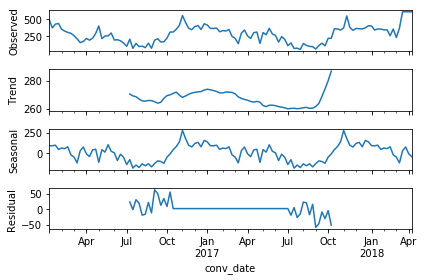

In [45]:
#seasonal decomposition
components = seasonal_decompose(df_week_delhi['value_AQI'])
components.plot()
plt.show()

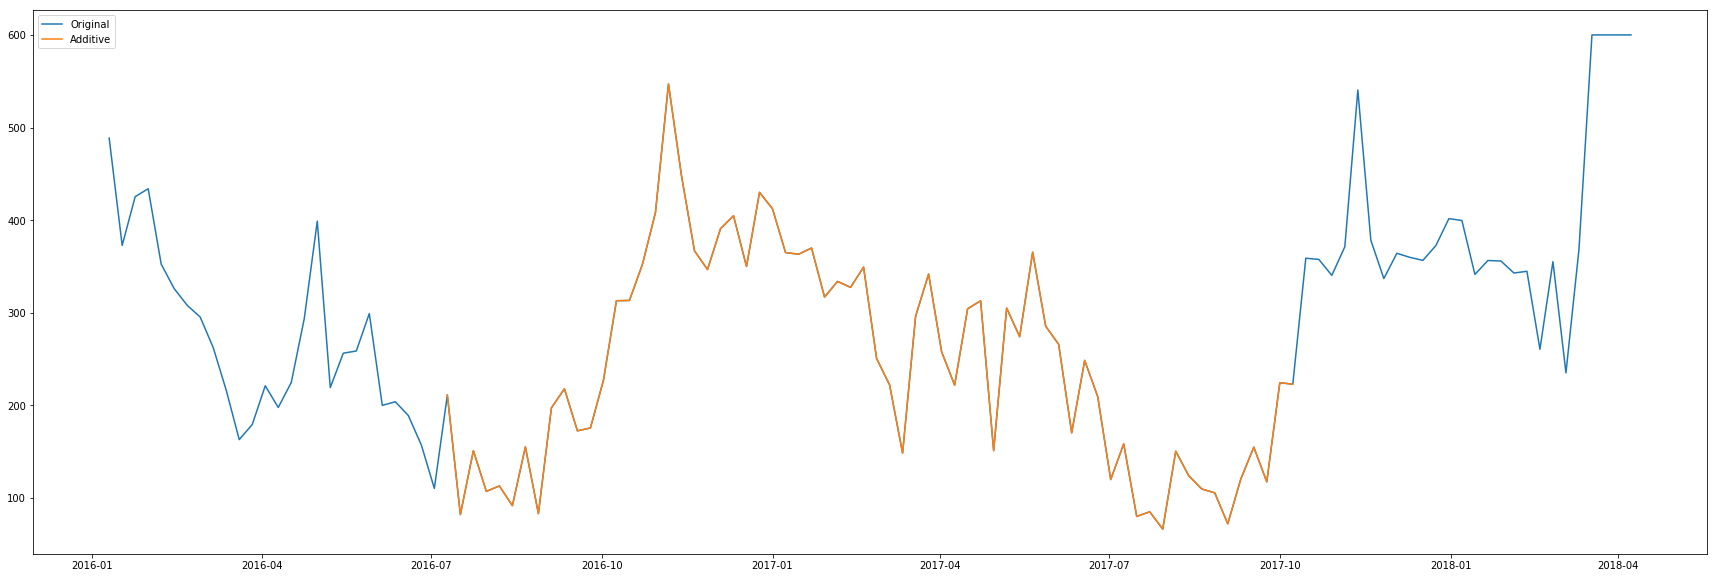

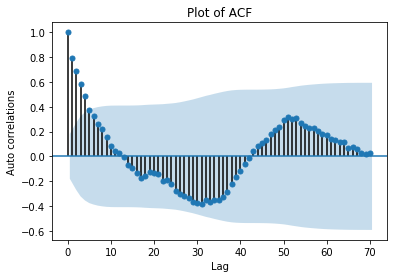

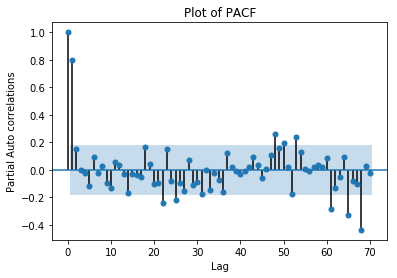

In [46]:
#For non stationary
plt.figure(figsize=(30,10))
additive = components.trend + components.seasonal + components.resid
multiplicative = components.trend * components.seasonal * components.resid
#print(additive.sample(30))
plt.plot(components.observed, label="Original")

plt.plot(additive, label="Additive")
#plt.plot(multiplicative, label="Multiplicative")
plt.legend()
plt.show()

plot_acf(df_week_delhi['value_AQI'], lags = 70)
plt.xlabel('Lag')
plt.ylabel('Auto correlations')
plt.title('Plot of ACF')
plt.show()

plot_pacf(df_week_delhi['value_AQI'], lags = 70)
plt.xlabel('Lag')
plt.ylabel('Partial Auto correlations')
plt.title('Plot of PACF')
plt.show()

In [47]:
#before converting to stationary
dftest = adfuller(df_week_delhi['value_AQI'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
#not stationary

df_week_delhi['value_AQI_diff'] = df_week_delhi['value_AQI'] - df_week_delhi['value_AQI'].shift(1)
#Repeating the 0th value for the NA
df_week_delhi['value_AQI_diff'][0] = df_week_delhi['value_AQI'][0]

#Performing the Dickey Fuller test
print("\n\nperforming differencing and then dickey fuller\n\n")
dftest = adfuller(df_week_delhi['value_AQI_diff'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
#became stationary

Test Statistic                  -1.993381
p-value                          0.289483
#Lags Used                       4.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


performing differencing and then dickey fuller


Test Statistic                  -5.628729
p-value                          0.000001
#Lags Used                       3.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


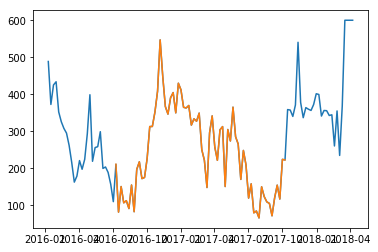

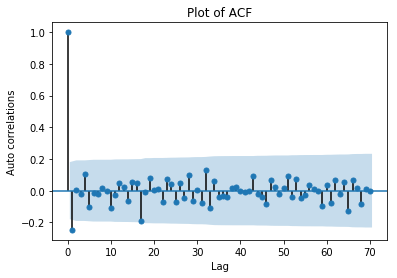

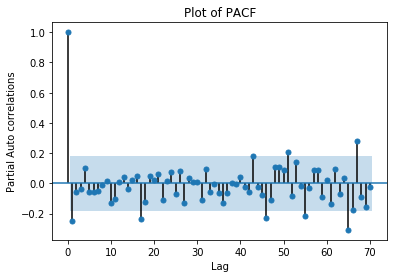

In [48]:
#After converting to stationary
additive = components.trend + components.seasonal + components.resid
plt.plot(components.observed, label="Original")
plt.plot(additive, label="Additive")

plot_acf(df_week_delhi['value_AQI_diff'], lags = 70)
plt.xlabel('Lag')
plt.ylabel('Auto correlations')
plt.title('Plot of ACF')
plt.show()

plot_pacf(df_week_delhi['value_AQI_diff'], lags = 70)
plt.xlabel('Lag')
plt.ylabel('Partial Auto correlations')
plt.title('Plot of PACF')
plt.show()

In [49]:
df_test_delhi = df_week_delhi[78:118]
df_train_delhi = df_week_delhi[0:78]

In [50]:
#We know that the order of differencing = 1  
#From the PACF plot we know that p should be = 1 and hence keep it fixed
import warnings
import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm

p=[0,1]
d=[0,1]
q=[0,1]

min_aic=10000
pdq = list(itertools.product(p, d, q))
print(pdq)
P=[i for i in range(0,3)]
#change this to 0,1,2
D=[0,1]
Q=[i for i in range(0,3)]
PDQ=list(itertools.product(P, D, Q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
print(seasonal_pdq)
#For possible combinations of (p,d,q) and (P,D,Q) we loop over and try to observe how the model performs
for param in pdq:
    print(param)
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_train_delhi.value_AQI.interpolate(),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            
            print('SARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            if(results.aic < min_aic):
                min_aic=results.aic
                min_param=param
                min_seasonal=param_seasonal
            
        except: 
            #print("Exception")
            continue

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12)]
(0, 0, 0)
SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1092.6339061922347
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:891.8232145180714
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:2723.6691560562426
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:837.3018296068329
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:668.1491018977274
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:846.0670499161655
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:817.5742411672701
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:674.373399701596
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:696.8488228472822
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:669.7844040910629
SARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:696.5136161497767
SARIMA(0, 0, 

In [51]:
#Printing the chosen parameters
print(min_param)
print(min_seasonal)
print(min_aic)

(1, 1, 0)
(2, 1, 0, 12)
468.20623060688285


In [52]:
#Model fitting
mod = sm.tsa.statespace.SARIMAX(df_train_delhi['value_AQI'],
                                order=min_param,
                                seasonal_order=min_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3446      0.201     -1.712      0.087      -0.739       0.050
ar.S.L12      -0.8088      0.192     -4.205      0.000      -1.186      -0.432
ar.S.L24      -0.3082      0.221     -1.392      0.164      -0.742       0.126
sigma2      5809.7952   1357.912      4.278      0.000    3148.337    8471.253


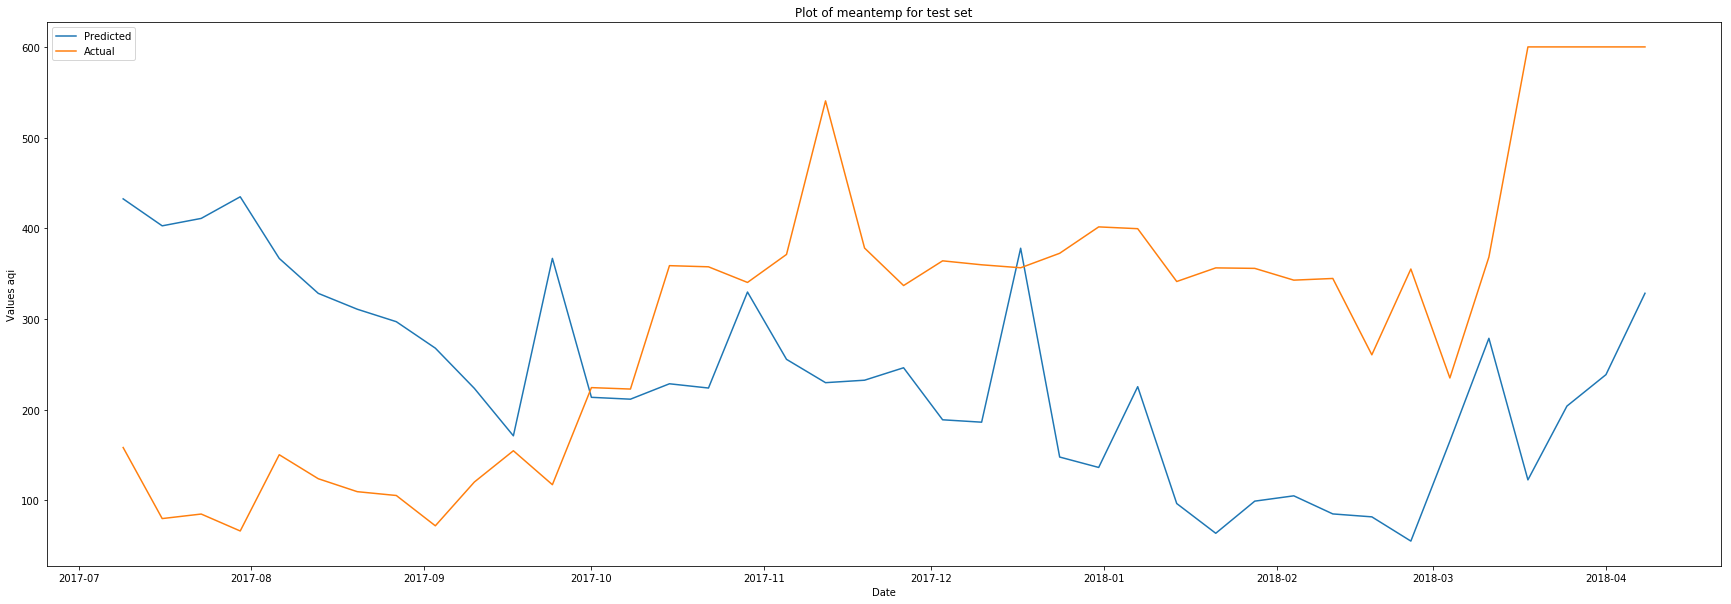

The Mean Squared Error is 53601.22
The Root Mean Squared Error is 231.52


In [53]:
#Predicting
yhat = results.predict(start=1, end=len(df_test_delhi['value_AQI']))
y_truth = df_test_delhi['value_AQI']
yhat.index=y_truth.index
plt.figure(figsize=(30,10))
plt.plot(yhat, label = "Predicted")
plt.plot(y_truth, label = "Actual")
plt.xlabel('Date')
plt.ylabel('Values aqi')
plt.title('Plot of meantemp for test set')
plt.legend(loc=2)
plt.show()
#Calculating error
mse = ((yhat - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The RMSE value obtained for the test set = 234.92 <br>The model does not seem to be doing a good job. <br>This forecast is not  accurate  since the AQI depends on instantaneous variables which cannot be accounted for in a simple SARIMA model.<br> Parameters such as rainfall, temperature, instantaneous weather parameters determine the Air Quality.<br>
A univariate time series model such as the one we have made will not provide substantial information in determining the air quality in the future.